# TP3 - 7.4 - SVM - Adrián José Zapater Reig

## 7.4.1 - Clasificación:
- Limpieza de datos
    - Estudio estadístico de room_type
- Clasificación usando SVC y LinearSVC
    - Afinación de SVC usando RBF
        - Encontrar el los mejores valores de gamma y c con GridSearchCV
        - Hacer 2+ busquedas usando numpy.logspace para generar las listas de parámetros. 
    

In [1]:
import os
import pandas as pd

In [2]:
data_path = os.path.join("data","airbnb.csv")
airbnb_raw = pd.read_csv(data_path)

In [3]:
airbnb_raw.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Centro,Justicia,40.424715,-3.698638,Entire home/apt,49,28,35,0.42,1,99
1,Centro,Embajadores,40.413418,-3.706838,Entire home/apt,80,5,18,0.30,1,188
2,Moncloa - Aravaca,Argüelles,40.424920,-3.713446,Entire home/apt,40,2,21,0.25,9,195
3,Moncloa - Aravaca,Casa de Campo,40.431027,-3.724586,Entire home/apt,55,2,3,0.13,9,334
4,Latina,Cármenes,40.403410,-3.740842,Private room,16,2,23,0.76,2,250


### En primer lugar estudiemos room_type

In [4]:
# Tenemos 3 etiquetas a clasificar: ['Entire home/apt' 'Private room' 'Shared room']
print(airbnb_raw['room_type'].unique())

['Entire home/apt' 'Private room' 'Shared room']


In [5]:
# Las etiquetas están repartidas de la siguiente manera:
airbnb_raw.groupby("room_type").size()

room_type
Entire home/apt    7926
Private room       5203
Shared room         192
dtype: int64

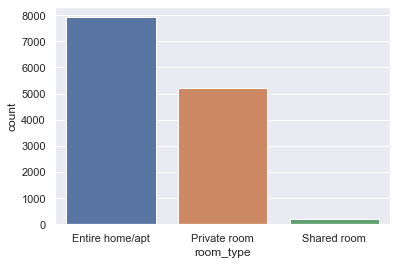

In [6]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.countplot(airbnb_raw["room_type"], label="room_type count")

Como podemos ver las etiquetas están desbalanceadas. Shared room tiene muchos registros que las primeras 2.
Los datos no están balanceado por lo que tendremos que tenerlo en cuenta a la hora de entrenar el modelo.

## Estudio estadístico:
En esta sección vamos a limpiar el dataset:

Dado que neighbourhood y neighbourhood_group nos dan la misma información (siendo neighbourhood mas precisa, quizás demasiado precisa) vamos a descartar neighbourhood del dataset.

Vamos a estudiar si hubiesen datos faltantes en alguna columna y sustituirlos por valores neutros (media de la columna para numéricos y eliminar el registro para categóricos puesto que no podemos darle un valor sin afectar a las conclusiones que se puedan sacar.)

In [7]:
airbnb_staged = airbnb_raw.drop("neighbourhood", 1, inplace=False)

In [8]:
airbnb_staged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13321 entries, 0 to 13320
Data columns (total 10 columns):
neighbourhood_group               13321 non-null object
latitude                          13321 non-null float64
longitude                         13321 non-null float64
room_type                         13321 non-null object
price                             13321 non-null int64
minimum_nights                    13321 non-null int64
number_of_reviews                 13321 non-null int64
reviews_per_month                 13321 non-null float64
calculated_host_listings_count    13321 non-null int64
availability_365                  13321 non-null int64
dtypes: float64(3), int64(5), object(2)
memory usage: 1.0+ MB


Como podemos ver, todas las columnas tienen valor para todos los registros distinto a nulo (indicador non-null y nº de registros igual al total). Por lo que no tendremos que añadir o eliminar registros.

#### Separar un test set
Usamos stratified test

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
# Separamos en 2 grupos con 0.2 en el test set.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Separamos el test y train set respetando la proporción de muestras por neighbourhood_group para tener representación 
# de todas las zonas en ambos conjuntos.
for train_id, test_id in split.split(airbnb_staged, airbnb_staged["neighbourhood_group"]):
    train_set_st, test_set_st = airbnb_staged.loc[train_id], airbnb_staged.loc[test_id]

y_train = train_set_st["room_type"]
x_train = train_set_st.drop("room_type", 1, inplace=False)

In [10]:
train_set_st["price"].count()

10656

In [11]:
test_set_st["price"].count()

2665

### Preprocesing
En esta sección vamos a escalar valores numéricos y transformar los datos categóricos a numéricos.

Como ya sabemos, los modelos SVC son muy sensibles a los valores no escaldos. Para maximizar su rendimiento, escalaremos estos valores con el StandardScaler de scikit learn.

Para que SVM pueda procesar los valores categóricos, vamos a utilizar el OneHotEncoder para crear tantas variables dummies como distintos valores categóricos y OrdinalEncoder para asignar un valor numérico a cata valor. Vamos a estudiar precisión de ambos modelos y nos quedaremos con el mejor.

In [14]:
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

label = ["room_type"]
cat_attribs = ["neighbourhood_group"]
num_attribs = ["latitude","longitude","price","minimum_nights","number_of_reviews","reviews_per_month","calculated_host_listings_count","availability_365"]


hot_col_trs = ColumnTransformer([
    ("num_scaler", StandardScaler(), num_attribs),
    ("cat_ordinal", OneHotEncoder(), cat_attribs),
])

ord_col_trs = ColumnTransformer([
    ("num_scaler", StandardScaler(), num_attribs),
    ("cat_ordinal", OrdinalEncoder(), cat_attribs),   
])


hot_linear_clf = Pipeline([
    ("col_trans", hot_col_trs),
    ("model", LinearSVC())
])

ord_linear_clf = Pipeline([
    ("col_trans", ord_col_trs),
    ("model", LinearSVC())
])


In [20]:
from sklearn.model_selection import cross_val_score

hot_linear_svm_scores = cross_val_score(hot_linear_clf, x_train, y_train.values.ravel(), cv=20, scoring="accuracy", n_jobs=-1)
hot_linear_svm_scores.min()
# 0.7335834896810507

0.7335834896810507

In [21]:
ord_linear_svm_scores = cross_val_score(ord_linear_clf, x_train, y_train.values.ravel(), cv=20, scoring="accuracy", n_jobs=-1)
ord_linear_svm_scores.min()
# 0.7861163227016885

0.7819548872180451

In [15]:
from sklearn.svm import SVC

hot_clf = Pipeline([
    ("hot_col_trs",hot_col_trs),
    ("model", SVC())
])

ord_clf = Pipeline([
    ("ord_col_trs",ord_col_trs),
    ("model", SVC())
])

In [23]:
hot_linear_svm_scores = cross_val_score(hot_clf, x_train, y_train.values.ravel(), cv=20, scoring="accuracy", n_jobs=-1)
hot_linear_svm_scores.min()
# 0.8686679174484052

0.8555347091932458

In [24]:
ord_linear_svm_scores = cross_val_score(ord_clf, x_train, y_train.values.ravel(), cv=20, scoring="accuracy", n_jobs=-1)
ord_linear_svm_scores.min()
# 0.8461538461538461

0.8592870544090057

Como era de esperar, el SVC con valores por defecto obtiene una puntuación mejor que el linear. Esto puede ser porque, dados los datos que tenemos, no es facil separarlos con una única línea.

El Ordinal enconder ha dado mejor resultado en la primera prueba. Sospecho que realmente es por overfitting ya que al usar el OrdinalEncoder y asignar números a las categorías, estamos indicando que cieetas categorias están relacionadas cuando no existe esta relación. En la segunda prueba vemos que el one hot onbtiene un resultado mejor aunque no muy alejado de Ordinal.

### Afinación de Hyperparámetros:
Como dice el enunciado, vamos a buscar gamma y C para SVC con kernel = RBF.

Primero haremos una busqueda amplia para encontrar la zona donde tenemos mejor resultado. En segundo lugar haremos una búsqueda enfocada en la zona de mejor resultado.

In [18]:
# Coarse search
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {
    'model__C' : np.logspace(-15, 15, base=2, num=5),
    'model__gamma' : np.logspace(-15, 15, base=2, num=5),
    'model__kernel' : ['rbf'],
    'model__class_weight' : ['balanced']
    
}

grid_search = GridSearchCV(hot_clf, param_grid, cv=10, n_jobs=-1)
grid_res = grid_search.fit(x_train, y_train)
grid_res.best_params_

#{'model__C': 32768.0,  -> 2^15
# 'model__class_weight': 'balanced',
# 'model__gamma': 0.005524271728019903,  -> 2^-7.5
# 'model__kernel': 'rbf'}

/Users/adzarei/Documents/UNED/ING_CIENC_DATOS/projects/AAI/conda-env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'model__C': 32768.0,
 'model__class_weight': 'balanced',
 'model__gamma': 0.005524271728019903,
 'model__kernel': 'rbf'}

Reajustamos C para que esté entre 2^13 y 2^33 y gamma entre 2^-10 y 2^5

In [20]:
# Coarse search 2
param_grid = {
    'model__C' : np.logspace(10, 20, base=2, num=5),
    'model__gamma' : np.logspace(-10, 0, base=2, num=5),
    'model__kernel' : ['rbf'],
    'model__class_weight' : ['balanced']   
}

grid_search = GridSearchCV(hot_clf, param_grid, cv=10, n_jobs=-1, verbose=True)
grid_res = grid_search.fit(
    , y_train)
grid_res.best_params_
#{'model__C': 32768.0,
# 'model__class_weight': 'balanced',
# 'model__gamma': 0.03125,
# 'model__kernel': 'rbf'}

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 49.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 429.8min finished


{'model__C': 32768.0,
 'model__class_weight': 'balanced',
 'model__gamma': 0.03125,
 'model__kernel': 'rbf'}

c = 2^15
gamma = 2^-5


In [21]:
grid_res.best_score_
#0.8584834834834835

0.8584834834834835

In [25]:
# Fine search
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {
    'model__C' : np.logspace(14.5, 15.5, base=2, num=5),
    'model__gamma' : np.logspace(-8, -4, base=2, num=5),
    'model__kernel' : ['rbf'],
    'model__class_weight' : ['balanced']
    
}

grid_search = GridSearchCV(hot_clf, param_grid, cv=10, n_jobs=-1, verbose=True)
grid_res = grid_search.fit(x_train, y_train)
grid_res.best_params_

#{'model__C': 46340.95001184158,
# 'model__class_weight': 'balanced',
# 'model__gamma': 0.03125,
# 'model__kernel': 'rbf'}

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 43.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 66.5min finished


{'model__C': 46340.95001184158,
 'model__class_weight': 'balanced',
 'model__gamma': 0.03125,
 'model__kernel': 'rbf'}

c = 2^15.5

gamma = 2^-5

## Resultado final
Vamos a evaluar el modelo con el test set para evaluar el rendimiento final con los hyperparámetros optimizados que hemos calculado.

In [16]:
y_test = test_set_st["room_type"]
x_test = test_set_st.drop("room_type", 1, inplace=False)

In [18]:
from sklearn.metrics import confusion_matrix

final_clf = Pipeline([
    ("hot_col_trs",hot_col_trs),
    ("model", SVC( C=46340.95001184158, gamma=0.0312, kernel='rbf', class_weight='balanced', verbose=True)) # Params
])

final_clf.fit(x_train, y_train)
clf_predict = final_clf.predict(x_test)

[LibSVM]

array([[1440,  142,   10],
       [ 141,  833,   67],
       [   5,   11,   16]])

In [21]:
room_type_enum = ['Entire home/apt','Private room','Shared room']

cm = confusion_matrix(y_test, clf_predict, room_type_enum)

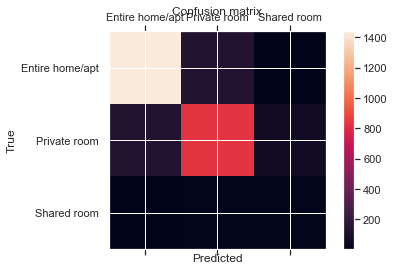

In [32]:
fig = plt.figure() 
ax = fig.add_subplot(111) 
cax = ax.matshow(cm) 
plt.title('Confusion matrix') 
fig.colorbar(cax) 
ax.set_xticklabels([''] + room_type_enum) 
ax.set_yticklabels([''] + room_type_enum) 
plt.xlabel('Predicted') 
plt.ylabel('True') 
plt.show()

In [25]:
print(cm)

[[1440  142   10]
 [ 141  833   67]
 [   5   11   16]]


### Conclusiones:

Vamos a calcular la precisión y el recall y evaluar los resultados.

### Precision: TP/(TP+FP)

Entire home/apt:

In [44]:
#1440 / (1440 + 141 + 5) = 0.9079445145018915
1440 / (1440 + 141 + 5)

0.9079445145018915

Private room

In [47]:
# 833 / (142 + 833 + 11) = 0.8448275862068966
833 / (142 + 833 + 11)

0.8448275862068966

Shared room

In [49]:
# 16 / (67  + 10 +  16) = 0.17204301075268819
16 / (67  + 10 +  16)

0.17204301075268819

### Recall: TP /(TP + FN)

Entire home/apt:

In [34]:
#1440 / (1440 + 142 + 10) = 0.9045226130653267
1440 / (1440 + 142 + 10)

0.9045226130653267

Private room

In [35]:
# 833 / (141 + 833 + 67) = 0.8001921229586936
833 / (141 + 833 + 67)

0.8001921229586936

Shared room

In [37]:
# 16 / (5  + 11 +  16) = 0.5
16 / (5  + 11 +  16)

0.5

Como era de esperar, hemos logrado muy buenos resultados para todas las categorías menos Shared room. Esto se debe a que Shared room tenía muy pocos registros para entrenar el modelo. Si lograsemos obtener mas ejemplos con los que entrenart el modelo, seguramente podríamos mejorar su resultado.

El peor resultado del modelo lo vemos en la precisión de Shared Room, que muestra que solo un 17% de los shared rooms que se han predecido, se han logrado clasificar correctamente. Por el contrario, su recall indica que, de un 50% de todos los registros de su tipo se han clasificado correctamente.

En general, estoy contento con el modelo. Como punto de mejora, asumiendo que no tenemos nuevos datos con los que entrenar el modelo, balancearía las 3 categorías añadiendo nuevos registros "ficticios" con la media de cada columna para shared room.